# Emotion Recognition using RNN


## 0. Instal Hugging Face's nlp package

In [417]:
# !pip install nlp

## 1. Import the Libaries

In [460]:
import nlp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [419]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Import the Dataset & Visualize the Distributions

In [ ]:
dataset = nlp.load_dataset('emotion')

In [452]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [451]:
train = dataset['train']
train[20]

{'label': 'anger',
 'text': 'i feel irritated and rejected without anyone doing anything or saying anything'}

In [423]:
# Get lists of tweets & labels
def get_tweets(data):
    tweets = [d['text'] for d in data]
    labels = [d['label'] for d in data]
    return tweets, labels

tweets, labels = get_tweets(train)

{'label': 'anger',
 'text': 'i feel irritated and rejected without anyone doing anything or saying anything'}

In [424]:
# get classes
classes =   list(set(labels))
classes

['anger', 'sadness', 'surprise', 'love', 'fear', 'joy']

In [425]:
# Count each class
counts = [labels.count(c) for c in classes]
counts

[2159, 4666, 572, 1304, 1937, 5362]

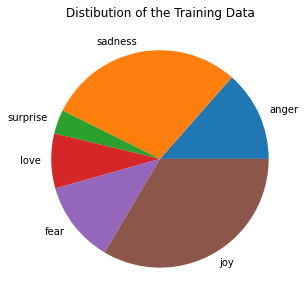

In [426]:
fig = plt.figure(figsize =(5,5))
plt.pie(counts, labels = classes)
plt.title('Distibution of the Training Data')
plt.show()

In [427]:
print('Attention: There is an inbalance in the dataset', ',which may cause issues in the predictions!')

Attention: There is an inbalance in the dataset ,which may cause issues in the predictions!


## 3. Relabel the Emotions in the Dataset

In [428]:
# convert the classes to nums =  [0,1,2,3,4,5]

nums_to_names = dict(enumerate(classes))
names_to_nums = {v:k for (k,v) in nums_to_names.items()}
nums_to_names, names_to_nums

({0: 'anger', 1: 'sadness', 2: 'surprise', 3: 'love', 4: 'fear', 5: 'joy'},
 {'anger': 0, 'sadness': 1, 'surprise': 2, 'love': 3, 'fear': 4, 'joy': 5})

In [429]:
def relabel_names_to_nums(names_to_nums, labels):
    new_labels = [names_to_nums[label]  for label in labels]     
    return new_labels

def load_datasets(data, names_to_nums):
    DATA_COLUMN = 'tweets'
    LABEL_COLUMN = 'labels'
    tweets, labels = get_tweets(data)
    new_labels = relabel_names_to_nums(names_to_nums, labels)
    dataframe = pd.DataFrame(list(zip(tweets, new_labels)),
               columns =[DATA_COLUMN, LABEL_COLUMN])
    return dataframe

In [430]:
test, val = dataset['test'], dataset['validation']

train_df = load_datasets(train, names_to_nums)
test_df = load_datasets(test, names_to_nums)
val_df = load_datasets(val, names_to_nums)

## 4. Get the Maximum Length of the Tweets

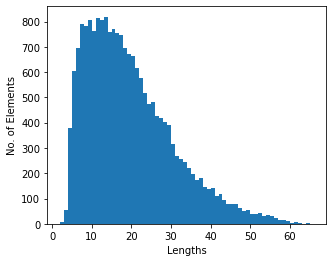

In [431]:
tweets = list(train_df[DATA_COLUMN]) + list(test_df[DATA_COLUMN]) + list(val_df[DATA_COLUMN])
lengths = [len(text.split(' ')) for text in tweets]

fig = plt.figure(figsize = (5,4))
plt.hist(lengths, bins=len(set(lengths)))
plt.xlabel('Lengths')
plt.ylabel('No. of Elements')
plt.show()

In [432]:
max_length = (max(lengths)//10 +1)*10 
max(lengths), max_length

(66, 70)

## 5. Tokenize the Tweets & Pad Sequences

In [433]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[20]]))

[[2, 3, 497, 4, 548, 174, 260, 149, 163, 35, 369, 163]]


In [434]:
df_train = train_df.sample(frac =1)
df_test = test_df.sample(frac =1)
df_val = val_df.sample(frac =1)

In [527]:
def prepare_datasets(tokenizer, Dataframe):
    DATA_COLUMN = 'tweets'
    LABEL_COLUMN = 'labels'
    ### get_sequences
    tweets = list(Dataframe[DATA_COLUMN])
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_length, padding='post')
    ### get labels -- np.array
    labels = np.array(Dataframe[LABEL_COLUMN])
    #####
    return tweets, padded_sequences, labels

train_tweets, train_padded_sequences,  train_labels = prepare_datasets(tokenizer, df_train)
test_tweets, test_padded_sequences,  test_labels = prepare_datasets(tokenizer, df_test)
val_tweets, val_padded_sequences,  val_labels = prepare_datasets(tokenizer, df_val)

## 6. Create the Model

In [436]:
# 
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=max_length, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax'),
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 70, 16)            160000    
                                                                 
 bidirectional_46 (Bidirecti  (None, 70, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_47 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 40)                0         
                                                                 
 dense_28 (Dense)            (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-t

## 7. Train the Model

In [437]:
print(f'Beginning Training!', '\n')
current_time = datetime.now()

h = model.fit(
    train_padded_sequences, train_labels,
    validation_data=(val_padded_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

print('\n', "Training took time ", datetime.now() - current_time)

Beginning Training! 

Epoch 1/15
500/500 [==============================] - 51s 85ms/step - loss: 1.2922 - accuracy: 0.4888 - val_loss: 0.8060 - val_accuracy: 0.7180
Epoch 2/15
500/500 [==============================] - 39s 77ms/step - loss: 0.6075 - accuracy: 0.7985 - val_loss: 0.5571 - val_accuracy: 0.8135
Epoch 3/15
500/500 [==============================] - 39s 78ms/step - loss: 0.3731 - accuracy: 0.8829 - val_loss: 0.5287 - val_accuracy: 0.8375
Epoch 4/15
500/500 [==============================] - 39s 78ms/step - loss: 0.2633 - accuracy: 0.9234 - val_loss: 0.4513 - val_accuracy: 0.8610
Epoch 5/15
500/500 [==============================] - 42s 83ms/step - loss: 0.2188 - accuracy: 0.9344 - val_loss: 0.4613 - val_accuracy: 0.8720
Epoch 6/15
500/500 [==============================] - 38s 76ms/step - loss: 0.1592 - accuracy: 0.9553 - val_loss: 0.4712 - val_accuracy: 0.8740
Epoch 7/15
500/500 [==============================] - 39s 77ms/step - loss: 0.1331 - accuracy: 0.9624 - val_loss: 

## 8. Plot the Training History

In [438]:
list(h.history.keys())

['loss', 'accuracy', 'val_loss', 'val_accuracy']

In [510]:
def plot_history(h):
    epochs = len(h.history['loss'])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1,epochs+1), h.history.get('accuracy'), 'b-o', label='Training')
    plt.plot(range(1,epochs+1), h.history.get('val_accuracy'), 'k-o', label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Accuracy', fontsize = 12)
    plt.title('Epochs Vs Accuracy' , fontsize = 16)
    plt.legend(fontsize = 11)

    plt.subplot(1, 2, 2)
    plt.plot(range(1,epochs+1), h.history.get('loss'), 'b-*', label='Training')
    plt.plot(range(1,epochs+1), h.history.get('val_loss'), 'k-*', label='Validation')
#     plt.ylim([0., 1.])
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
    plt.title('Epochs Vs Loss' , fontsize = 16)
    plt.legend(fontsize = 11)
    plt.show()

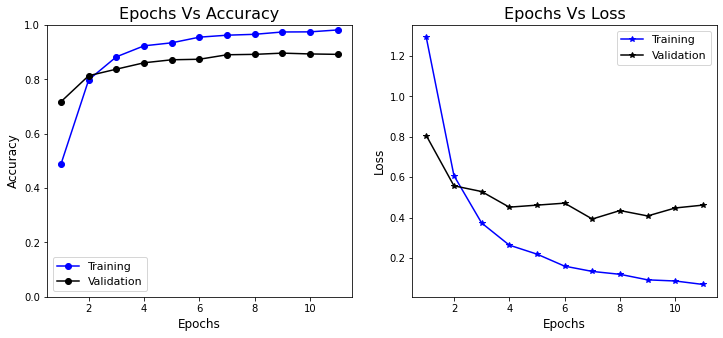

In [511]:
plot_history(h)

## 9. Evaluate the Model

In [577]:
eval = model.evaluate(test_padded_sequences, test_labels)

63/63 [==============================] - 5s 73ms/step - loss: 0.4423 - accuracy: 0.8950


In [578]:
def get_padded_sequences(pred_sentences, tokenizer):
    ### get_sequences
    sequences = tokenizer.texts_to_sequences(pred_sentences)
    ###
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_length, padding='post')    
    return padded_sequences

def predictions(pred_sentences):
    pred_sequences = get_padded_sequences(pred_sentences, tokenizer=tokenizer)
    predicts = model.predict(pred_sequences)
    classes=np.argmax(predicts, axis=-1)
    return  [(sentence, nums_to_names[class_]) for sentence, class_ in zip(pred_sentences, classes)]

In [579]:
# Radomly select # 5 # tweets from test_dataframe & predict 
num_to_select = 5

pred_samples = df_test.sample(num_to_select)
selected_sentences = list(pred_samples[DATA_COLUMN])

selected_label_nums = list(pred_samples[LABEL_COLUMN])
selected_labels = [nums_to_names[x] for x in selected_label_nums]

preds = predictions(selected_sentences)
preds

1/1 [==============================] - 0s 39ms/step


[('i feel like it add a little bit more shield from the cold and the fabric is great for wicking away sweat',
  'anger'),
 ('i have a feeling i will be dissatisfied several times', 'anger'),
 ('i feel like everythings going to happen with out me and that ive been disillusioned this whole time',
  'sadness'),
 ('i write this th post i feel extremely delighted to buy myself a little corner in this blogger world',
  'joy'),
 ('i can cycle further than ever before and the feeling of finishing the manchester to blackpool miles then not being at all bothered at having to ride an extra mile to put',
  'anger')]

In [580]:
predicted_labels = [v for (k,v) in preds]
predicted_labels, selected_labels

(['anger', 'anger', 'sadness', 'joy', 'anger'],
 ['anger', 'anger', 'sadness', 'joy', 'anger'])

In [581]:
#  Predict the whole test_data
test_tweets, test_labels = get_tweets(test)
preds = predictions(test_tweets)
predicted_labels = [v for (k,v) in preds]

63/63 [==============================] - 4s 69ms/step


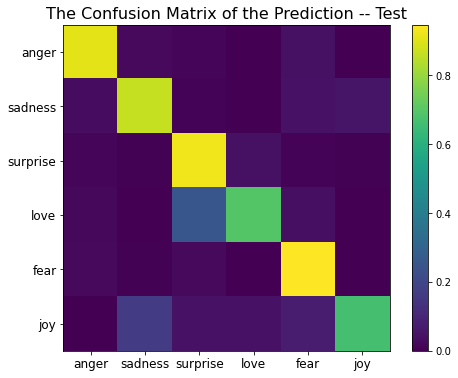

In [582]:
# Plot the confusion_matrix of the prediction

def plot_confusion_matrix(val_true, val_pred, classes):  
    
    cm = confusion_matrix(val_true, val_pred, normalize='true')
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    color_cm = ax.matshow(cm)
    
    plt.xticks(range(len(classes)), labels=classes, fontsize = 12)
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    plt.yticks(range(len(classes)), labels=classes, fontsize = 12)
    plt.colorbar(color_cm)
    plt.title('The Confusion Matrix of the Prediction -- Test' , fontsize = 16)
    plt.show()

plot_confusion_matrix(test_labels, predicted_labels, classes)

## 10. Predict Inputs 

In [583]:
pred_sentences = [
  "That movie was absolutely awful!",
  "This is bloodly good",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "Go to the hell!",
  "You are so stupid!",
  "I don't belong here and must leave right now!"
]

In [584]:
preds = predictions(pred_sentences)
preds

1/1 [==============================] - 0s 76ms/step


[('That movie was absolutely awful!', 'sadness'),
 ('This is bloodly good', 'joy'),
 ('The film was creative and surprising', 'joy'),
 ('Absolutely fantastic!', 'joy'),
 ('Go to the hell!', 'anger'),
 ('You are so stupid!', 'sadness'),
 ("I don't belong here and must leave right now!", 'sadness')]

In [585]:
predicted_labels = [v for (k,v) in preds]
predicted_labels

['sadness', 'joy', 'joy', 'joy', 'anger', 'sadness', 'sadness']

## 11. Save & Reload the Trained Model

In [586]:
saved_model_path = 'HuggingFace_nlp_emotion_RNN'

In [590]:
model.save(saved_model_path)

INFO:tensorflow:Assets written to: HuggingFace_nlp_emotion_RNN\assets


INFO:tensorflow:Assets written to: HuggingFace_nlp_emotion_RNN\assets


In [595]:
reloaded_model = tf.keras.models.load_model(saved_model_path)

In [596]:
def reloaded_model_predictions(pred_sentences):
    pred_sequences = get_padded_sequences(pred_sentences, tokenizer=tokenizer)
    predicts = reloaded_model.predict(pred_sequences)
    classes=np.argmax(predicts, axis=-1)
    return  [(sentence, nums_to_names[class_]) for sentence, class_ in zip(pred_sentences, classes)]

In [ ]:
pred_sentences = [
  "That movie was absolutely awful!",
  "This is bloodly good",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "Go to the hell!",
  "You are so stupid!",
  "I don't belong here and must leave right now!"
]

In [598]:
preds = reloaded_model_predictions(pred_sentences)
preds

1/1 [==============================] - 5s 5s/step


[('That movie was absolutely awful!', 'sadness'),
 ('This is bloodly good', 'joy'),
 ('The film was creative and surprising', 'joy'),
 ('Absolutely fantastic!', 'joy'),
 ('Go to the hell!', 'anger'),
 ('You are so stupid!', 'sadness'),
 ("I don't belong here and must leave right now!", 'sadness')]

In [599]:
predicted_labels = [v for (k,v) in preds]
predicted_labels

['sadness', 'joy', 'joy', 'joy', 'anger', 'sadness', 'sadness']